Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
x_train Shape:  (55000, 784)
y_train Shape:  (55000, 10)
x_test Shape:  (10000, 784)
y_test Shape:  (10000, 10)


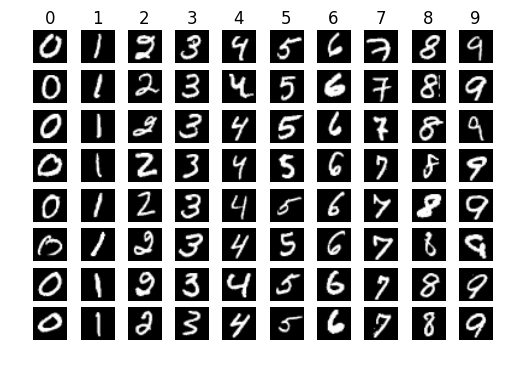

In [1]:
#-*- coding: utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# MNIST 객체로부터 데이터를 얻어온다.
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

print("x_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)
print("x_test Shape: ", x_test.shape)
print("y_test Shape: ", y_test.shape)


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_mnist(data, classes):
    
    for i in range(10):
        idxs = (classes == i) #조건에 맞는 index만 True 나머지는 False로 리턴된다.
        # 클래스 i에 해당하는 10개의 데이터
        images = data[idxs][0:10] #True조건을 만족하는 index로 data를 뽑고 그 중 10개를 뽑는다.
            
        for j in range(8):   
            plt.subplot(8, 10, i + j*10 + 1) # 행, 열, plot번호
            plt.imshow(images[j].reshape(28, 28), cmap='gray')
            # 클래스당 타이틀 표시
            if j == 0:
                plt.title(i)
            plt.axis('off')
    plt.show()

classes = np.argmax(y_train, 1) # [7 3 4 ..., 5 6 8] 형태로 출력된다.
plot_mnist(x_train, classes)

In [2]:
import tensorflow as tf


# Tensorboard 사용법
# tensorboard --logdir=path/to/log-directory
# TensorBoard operates by reading TensorFlow events files,
#  which contain summary data that you can generate when running TensorFlow.

def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean/' + name, mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev/' + name, stddev)
    tf.summary.scalar('max/' + name, tf.reduce_max(var))
    tf.summary.scalar('min/' + name, tf.reduce_min(var))
    tf.summary.histogram(name, var)

#### Computational Graph 셋팅 시작 ####
with tf.name_scope('input'):
  x = tf.placeholder(tf.float32, [None, 784], name="placeholder_mnist")  # 데이터 담을 placeholder 선언
  y_ = tf.placeholder(tf.float32, [None, 10], name="placeholder_TrueLabel") # True Label 값


with tf.name_scope('FC_Layer') as scope:
  with tf.name_scope('weights'):
    W = tf.Variable(tf.zeros([784, 10]), name="var_Weight") # 학습할 Weight Matrix
    variable_summaries(W, 'weights')
  with tf.name_scope('biases'):
    b = tf.Variable(tf.zeros([10]), name="var_Bias") # 학습할 bias
    variable_summaries(b, 'biases')
  with tf.name_scope('Wx_plus_b'):
    preactivate = tf.matmul(x, W) + b
    tf.summary.histogram('pre_activations', preactivate)
  y = tf.nn.softmax(preactivate) # 예측 Label 값
  tf.summary.histogram('softmax', y)


with tf.name_scope('cross_entropy'):
  cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=[1]), name="cross_entropy_ops") # Loss
  tf.summary.scalar('cross entropy', cross_entropy)

with tf.name_scope('train'):
  train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

with tf.name_scope('accuracy'):
  correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name="correct_prediction")
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
  tf.summary.scalar('accuracy', accuracy)
#### Computational Graph 셋팅 끝 ####


INFO:tensorflow:Summary name cross entropy is illegal; using cross_entropy instead.


In [3]:
merged = tf.summary.merge_all()

In [4]:
init = tf.global_variables_initializer() # 변수 초기화(텐서플로우 필수과정)

sess = tf.Session() # 세션 열기
sess.run(init) # 초기화

In [5]:
# Add ops to save and restore all the variables.
# Variables are saved in binary files that, roughly, contain a map from variable names to tensor values.
saver = tf.train.Saver() # 저장 대상이 모든 Variables 경우
# Add ops to save and restore only 'v2' using the name "my_v2"
#saver = tf.train.Saver({"my_v2": v2}) # 저장 대상이 일부 Variables 경우

In [6]:
train_writer = tf.summary.FileWriter('./train',
                                      sess.graph)
test_writer = tf.summary.FileWriter('./test')

In [7]:

for i in range(1000):

  if i % 10 == 0:  # Record summaries and test-set accuracy
    summary, acc = sess.run([merged, accuracy], feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    test_writer.add_summary(summary, i)
    print('Accuracy at step %s: %s' % (i, acc))
  if i % 100 == 99:  # Record execution stats, Starting at 99 and This code will emit runtime statistics for every 100th step
    batch_xs, batch_ys = mnist.train.next_batch(100)  # train, validation, test 에 데이터가 들어가 있음 #  return self._images[start:end], self._labels[start:end]
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()
    summary, _ = sess.run([merged, train_step], feed_dict={x: batch_xs, y_: batch_ys},
                            options=run_options, run_metadata=run_metadata)
    train_writer.add_run_metadata(run_metadata, 'step%d' % i)
    train_writer.add_summary(summary, i)
    print('Adding run metadata for', i)
  else:
    batch_xs, batch_ys = mnist.train.next_batch(100)
    summary, _ = sess.run([merged, train_step], feed_dict={x: batch_xs, y_: batch_ys})
    train_writer.add_summary(summary, i)



#### 테스트 세션 시작 ####
print(mnist.test.labels)
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
#### 테스트 세션 끝 ####



Accuracy at step 0: 0.098
Accuracy at step 10: 0.7821
Accuracy at step 20: 0.7874
Accuracy at step 30: 0.8696
Accuracy at step 40: 0.8557
Accuracy at step 50: 0.8609
Accuracy at step 60: 0.8809
Accuracy at step 70: 0.8604
Accuracy at step 80: 0.8832
Accuracy at step 90: 0.8828
Adding run metadata for 99
Accuracy at step 100: 0.8943
Accuracy at step 110: 0.8974
Accuracy at step 120: 0.8978
Accuracy at step 130: 0.8963
Accuracy at step 140: 0.8988
Accuracy at step 150: 0.8854
Accuracy at step 160: 0.8923
Accuracy at step 170: 0.9019
Accuracy at step 180: 0.8921
Accuracy at step 190: 0.9019
Adding run metadata for 199
Accuracy at step 200: 0.9037
Accuracy at step 210: 0.9065
Accuracy at step 220: 0.906
Accuracy at step 230: 0.9045
Accuracy at step 240: 0.9069
Accuracy at step 250: 0.8998
Accuracy at step 260: 0.8992
Accuracy at step 270: 0.9064
Accuracy at step 280: 0.9105
Accuracy at step 290: 0.9107
Adding run metadata for 299
Accuracy at step 300: 0.9083
Accuracy at step 310: 0.9087
Ac

In [11]:
# Save the variables to disk.
# 루프 안에서 주기적으로 저장할 경우는 아래와 같이 global_step을 인자로 넣음
# saver.save(sess, 'my-model', global_step=1000) ==> filename: 'my-model-1000'
import os
checkpoint_dir = "./save"
if not os.path.exists(checkpoint_dir): # 폴더 미리 있어야 하므로 생성
    os.makedirs(checkpoint_dir)
save_path = saver.save(sess, "./save/model.ckpt")
print("Model saved in file: %s" % save_path)


# Restore variables from disk.
#saver.restore(sess, "./save/model.ckpt")
#print("Model restored.")


Model saved in file: ./save/model.ckpt
